## Importing Libraries and Data

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#folderpath = "../Citibike_Project/Data/Prepared_data"
#df = pd.read_csv(os.path.join(folderpath, 'nyc_bike_weather_data.csv'),nrows=4800000, low_memory=False, encoding="utf-8", index_col = 0)

In [5]:
folderpath = "../Citibike_Project/Data/Prepared_data"
df = pd.read_pickle(os.path.join(folderpath, 'nyc_bike_weather_data.pkl'))

In [6]:
df.shape

(29838806, 16)

In [7]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'date', 'avgTemp', '_merge'],
      dtype='object')

In [8]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,date,avgTemp,_merge
0,BFD29218AB271154,electric_bike,2022-01-21 13:13:43.392,2022-01-21 13:22:31.463,West End Ave & W 107 St,7650.05,Mt Morris Park W & W 120 St,7685.14,40.802117,-73.968181,40.804038,-73.945925,member,2022-01-21,-6.0,both
1,7C953F2FD7BE1302,classic_bike,2022-01-10 11:30:54.162,2022-01-10 11:41:43.422,4 Ave & 3 St,4028.04,Boerum Pl\t& Pacific St,4488.09,40.673746,-73.985649,40.688489,-73.991160,member,2022-01-10,1.6,both
2,95893ABD40CED4B8,electric_bike,2022-01-26 10:52:43.096,2022-01-26 11:06:35.227,1 Ave & E 62 St,6753.08,5 Ave & E 29 St,6248.06,40.761227,-73.960940,40.745168,-73.986831,member,2022-01-26,-2.3,both
3,F853B50772137378,classic_bike,2022-01-03 08:35:48.247,2022-01-03 09:10:50.475,2 Ave & E 96 St,7338.02,5 Ave & E 29 St,6248.06,40.783964,-73.947167,40.745168,-73.986831,member,2022-01-03,1.4,both
4,7590ADF834797B4B,classic_bike,2022-01-22 14:14:23.043,2022-01-22 14:34:57.474,6 Ave & W 34 St,6364.10,5 Ave & E 29 St,6248.06,40.749640,-73.988050,40.745168,-73.986831,member,2022-01-22,-5.9,both


In [9]:
df.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at                      object
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
date                  datetime64[ns]
avgTemp                      float64
_merge                      category
dtype: object

## Data Wragling:

### Data Cleaning:

In [12]:
#Drop the merge flag
df.drop(columns = {'_merge'}, inplace = True)

In [13]:
#optimizing Memory Usage:
df['rideable_type'] = df['rideable_type'].astype('category')
df['ended_at'] = pd.to_datetime(df['ended_at'], errors='coerce')
df['start_station_name'] = df['start_station_name'].astype('category')
df['start_station_id'] = df['start_station_id'].astype('category')
df['end_station_name'] = df['end_station_name'].astype('category')
df['end_station_id'] = df['end_station_id'].astype('category')
df['start_lat'] = df['start_lat'].astype('float32')
df['start_lng'] = df['start_lng'].astype('float32')
df['end_lat'] = df['end_lat'].astype('float32')
df['end_lng'] = df['end_lng'].astype('float32')
df['member_casual'] = df['member_casual'].astype('category')
df['avgTemp'] = df['avgTemp'].astype('float32')

In [14]:
# Remove all rows with no average temperature data
df = df[~df['avgTemp'].isna()] 

In [15]:
#CLEANING DATA VALUES
df = df.copy()
df['member_casual'] = df['member_casual'].str.title()

In [16]:
df['rideable_type'] = df['rideable_type'].replace({'electric_bike':'Electric Bike', 'classic_bike':'Classic Bike'})

### CALCULATING TRIP DURATION

In [18]:
%%capture

# Make sure both the start and end time variables are datetime
df[['started_at','ended_at']] = df[['started_at','ended_at']].apply(pd.to_datetime)

In [19]:
%%capture

# Create a new column that calculates trip duration in seconds
df['trip_duration'] = (df['ended_at'] - df['started_at']).dt.seconds

### ISOLATING THE MONTH AND SEASON


In [21]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

In [22]:
df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12, 1, 2]
                                            else 'Spring' if x in [3, 4, 5]
                                            else 'Summer' if x in [6, 7, 8]
                                            else 'Fall')

### CALCULATING TOTAL DAILY BIKE RIDES


In [24]:
df=df.assign(value=1)
df_group = df.groupby('date', as_index=False).agg({'value': 'sum'})
df_group.rename(columns = {'value':'bike_rides_daily'}, inplace = True)
df = df.merge(df_group, on = "date", how = 'outer', indicator = True)
print(df['_merge'].value_counts(dropna = False))

both          29838166
left_only            0
right_only           0
Name: _merge, dtype: int64


### OUTLIERS:

In [26]:
# Calculating Q1, Q3, and the interquartile range
Q1 = df['trip_duration'].quantile(0.25)
Q3 = df['trip_duration'].quantile(0.75)
IQR = Q3 - Q1
print('The interquartile range is ' + str(IQR))

The interquartile range is 732.0


In [27]:
# Subsetting the dataset to count the number of outliers
outliers = df['trip_duration'][df['trip_duration'] > (Q3 + 1.5 * IQR)]
num_outliers = len(outliers)
max_outlier = outliers.max()
min_outlier = outliers.min()

In [28]:
# Displaying the results
print(f'Number of outliers: {num_outliers}')
print(f'Max outlier value: {max_outlier}')
print(f'Min outlier value: {min_outlier}')

Number of outliers: 1883666
Max outlier value: 86399
Min outlier value: 2178


In [29]:
# Calculating the percentage of outliers
total_trips = len(df)
outlier_percentage = (num_outliers * 100) / total_trips
print(f'{outlier_percentage:.2f}% of the trip durations are outliers')

6.31% of the trip durations are outliers


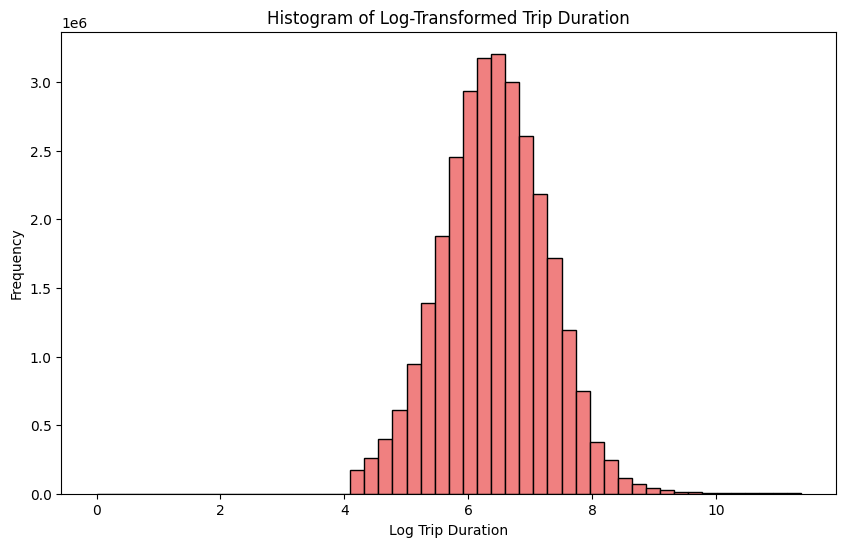

In [30]:
# Apply log transformation
df['log_trip_duration'] = np.log1p(df['trip_duration'])  # log1p handles zero values safely

# Visualize the transformed data
plt.figure(figsize=(10, 6))
plt.hist(df['log_trip_duration'], bins=50, color='lightcoral', edgecolor='black')
plt.title('Histogram of Log-Transformed Trip Duration')
plt.xlabel('Log Trip Duration')
plt.ylabel('Frequency')
plt.show()

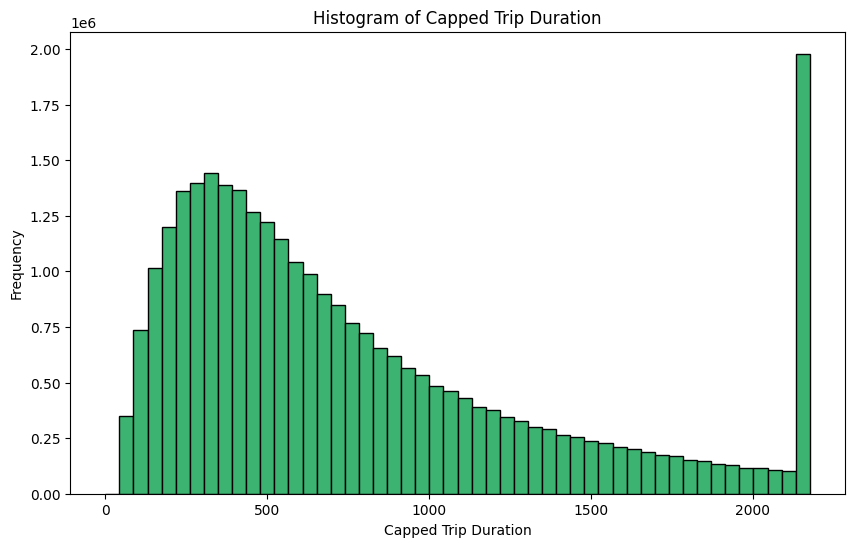

In [31]:
# Define the upper limit for outliers
upper_limit = Q3 + 1.5 * IQR

# Cap the values above the upper limit
df['trip_duration_capped'] = df['trip_duration'].clip(upper=upper_limit)

# Visualize the capped data
plt.figure(figsize=(10, 6))
plt.hist(df['trip_duration_capped'], bins=50, color='mediumseagreen', edgecolor='black')
plt.title('Histogram of Capped Trip Duration')
plt.xlabel('Capped Trip Duration')
plt.ylabel('Frequency')
plt.show()

In [32]:
# Recalculate outliers after capping
outliers_after_capping = df['trip_duration_capped'][df['trip_duration_capped'] > upper_limit]

# Percentage of outliers after capping
outlier_percentage_after_capping = (len(outliers_after_capping) * 100) / len(df)
print(f'{outlier_percentage_after_capping:.2f}% of the trip durations are still outliers (after capping).')

0.00% of the trip durations are still outliers (after capping).


The capping successfully adjusted all extreme values within the acceptable range, ensuring no data distortion.

In [34]:
df['trip_duration'] = df['trip_duration_capped']
df.drop(columns=['trip_duration_capped'], inplace=True)  #to cleanup

In [35]:
df_final = df.drop(columns = '_merge')

## Final Check: 

In [37]:
df_final.shape

(29838166, 21)

In [38]:
df_final.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'date', 'avgTemp', 'trip_duration', 'month', 'season',
       'value', 'bike_rides_daily', 'log_trip_duration'],
      dtype='object')

In [39]:
df_final.dtypes


ride_id                       object
rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name          category
start_station_id            category
end_station_name            category
end_station_id              category
start_lat                    float32
start_lng                    float32
end_lat                      float32
end_lng                      float32
member_casual                 object
date                  datetime64[ns]
avgTemp                      float32
trip_duration                  int64
month                          int64
season                        object
value                          int64
bike_rides_daily               int64
log_trip_duration            float64
dtype: object

In [40]:
df_final.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_lng,member_casual,date,avgTemp,trip_duration,month,season,value,bike_rides_daily,log_trip_duration
0,BFD29218AB271154,Electric Bike,2022-01-21 13:13:43.392,2022-01-21 13:22:31.463,West End Ave & W 107 St,7650.05,Mt Morris Park W & W 120 St,7685.14,40.802116,-73.968178,...,-73.945923,Member,2022-01-21,-6.0,528,1,Winter,1,33598,6.270988
1,096AE4C21473D1D6,Electric Bike,2022-01-21 20:32:55.968,2022-01-21 20:35:20.227,Riverside Dr & W 91 St,7524.16,Riverside Dr & W 82 St,7388.10,40.793137,-73.977005,...,-73.981277,Member,2022-01-21,-6.0,144,1,Winter,1,33598,4.976734
2,B3996D7CAEDF7B92,Classic Bike,2022-01-21 09:14:04.856,2022-01-21 09:18:53.000,Henry St & Atlantic Ave,4531.05,Clinton St & Tillary St,4748.07,40.690891,-73.996124,...,-73.991417,Member,2022-01-21,-6.0,288,1,Winter,1,33598,5.666427
3,83AE874442FFF355,Electric Bike,2022-01-21 17:30:27.244,2022-01-21 17:36:00.300,Cleveland Pl & Spring St,5492.05,Rivington St & Ridge St,5406.02,40.722103,-73.997246,...,-73.983299,Member,2022-01-21,-6.0,333,1,Winter,1,33598,5.811141
4,8B1950B6ED5BD50A,Electric Bike,2022-01-21 10:12:57.242,2022-01-21 10:31:37.016,1 Ave & E 62 St,6753.08,Allen St & Rivington St,5414.06,40.761227,-73.960938,...,-73.989975,Member,2022-01-21,-6.0,1119,1,Winter,1,33598,7.021084


In [47]:
# Define destination path
destpath = "../Citibike_Project/Data/Prepared_data"

# Export the DataFrame to a pickle file
df_final.to_pickle(os.path.join(destpath, 'cleaned_nyc_bike_weather_data.pkl'))